In [1]:
import pandas as pd
import os
from pysam import VariantFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce
from cyvcf2 import VCF
import pyupset as pyu

plt.style.use('aa_paper')
%matplotlib inline

def translate_gene_name(gene_name):
    """
    HDF5 throws all sort of errors when you have weird punctuation in the gene name, so
    this translates it to a less offensive form.
    """
    repls = ('-', 'dash'), ('.', 'period')
    trans_gene_name = reduce(lambda a, kv: a.replace(*kv), repls, str(gene_name))
    return trans_gene_name

# Reformat VCFs in parallel

`/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/reformat_variants_wtc_hg19_1.sh` (1-4) to parallelize 313762 regions defined in the 1000 Genomes hg19 region splitting.

Using a script called `get_gens_df.py` in `AlleleAnalyzer/generate_gens_dfs/get_gens_df.py`, we reformat the WTC VCF in order to more easily annotate variants for whether they are near or in PAM sites. This is necessary because in ordinary VCF files, variants can have multiple alleles listed on one line, and these need to be split up for annotation based on each individual allele. 

In [2]:
hg19_regions = pd.read_csv('../1000genomes_analysis/dat/1kgp_hg19_regions.bed', sep='\t', header=None,
                          names=['chrom','start','stop','region_id'])

In [3]:
hg19_regions['gens_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_formatted_variants/' + hg19_regions['region_id'] + '.h5'

hg19_regions['gens_complete'] = hg19_regions['gens_fname'].map(os.path.isfile)

In [6]:
hg19_regions.query('~gens_complete')[~hg19_regions['chrom'].str.contains('_')]

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,chrom,start,stop,region_id,gens_fname,gens_complete


# Annotate variants in parallel

`/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/annotate_variants_wtc_1.sh` 1-4 to account for number of jobs.

In [7]:
hg19_regions.head()

,chrom,start,stop,region_id,gens_fname,gens_complete
0,chr1,0,10000,region_0,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
1,chr1,10000,20000,region_1,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
2,chr1,20000,30000,region_2,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
3,chr1,30000,40000,region_3,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
4,chr1,40000,50000,region_4,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True


In [8]:
# see which regions have annotation files

hg19_regions['annots_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_annotated_variants/' + hg19_regions['region_id'] + '.h5' 
hg19_regions['annots_complete'] = hg19_regions['annots_fname'].map(os.path.isfile)

In [9]:
hg19_regions.query('annots_complete').tail()

,chrom,start,stop,region_id,gens_fname,gens_complete,annots_fname,annots_complete
309573,chr21,48070000,48080000,region_309573,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
309574,chr21,48080000,48090000,region_309574,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
309575,chr21,48090000,48100000,region_309575,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
309576,chr21,48100000,48110000,region_309576,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True
309577,chr21,48110000,48120000,region_309577,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True,/pollard/data/projects/AlleleAnalyzer_data/wtc...,True


In [10]:
hg19_regions.to_csv('/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/regions_w_fnames.tsv',
                   sep='\t')

# ExcisionFinder analysis + single guide targetability analyses

Running single cut targetability analysis:



In [3]:
test = pd.read_hdf('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom/chr11_ef_res')


In [5]:
genes = pd.read_csv('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv',
                   sep='\t')

In [6]:
genes.head()

,official_gene_symbol,name,chrom,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,size
0,A1BG,NM_130786.3,chr19,58858171,58864865,58858387,58864803,8,"58858171,58858718,58861735,58862756,58863648,5...","58858395,58859006,58862017,58863053,58863921,5...",6694
1,A1BG-AS1,NR_015380.2,chr19,58863335,58866549,58866549,58866549,4,"58863335,58864744,58865079,58865734,","58864410,58864840,58865223,58866549,",3214
2,A1CF,NM_001198820.1,chr10,52559168,52645435,52566488,52610547,14,"52559168,52569653,52570799,52573616,52575765,5...","52566640,52569802,52570936,52573798,52576039,5...",86267
3,A2M,NM_001347424.1,chr12,9220303,9268825,9220418,9265102,36,"9220303,9220778,9221335,9222340,9223083,922495...","9220435,9220820,9221438,9222409,9223174,922508...",48522
4,A2M-AS1,NR_026971.1,chr12,9217772,9220651,9220651,9220651,3,"9217772,9218421,9218751,","9217824,9218656,9220651,",2879


Identify targetable genes per person by each method:

Dual-sgRNA approach:

`python /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/targ_genes_per_person.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/samples.txt /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results/ /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results/`

Single-sgRNA approach:

`python /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/targ_genes_per_person_single.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/samples.txt /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ/ /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ/`

Dual-sgRNA approach + 5kb:

`python /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/targ_genes_per_person.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/samples.txt /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results_5kb/ /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results_5kb/`

Single-sgRNA approach:

`python /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/targ_genes_per_person_single.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/wtc_analysis/src/hg19_analysis/samples.txt /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ_5kb/ /pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ_5kb/`

# Determine # putatively targetable genes in WTC

In [2]:
genes = pd.read_csv('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv',
                   sep='\t')
autosomal_genes = genes.query('(chrom != "chrX") and (chrom != "chrY")')
protein_coding_autosomal_genes = set(genes[genes['name'].str.startswith('NM')]['official_gene_symbol'].tolist())

In [31]:
targ_genes_per_person = np.load('/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results/genes_per_person.npy').item()
targ_genes_per_person_single = np.load('/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ/genes_per_person.npy').item()
targ_genes_per_person_5kb = np.load('/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_excisionfinder_results_5kb/genes_per_person.npy').item()
targ_genes_per_person_single_5kb = np.load('/pollard/data/projects/AlleleAnalyzer_data/wtc_data/hg19/wtc_single_targ_5kb/genes_per_person.npy').item()

In [32]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

54.84046607862354

In [33]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person_5kb:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person_5kb[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

64.43972557987586

In [34]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person_single:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person_single[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

26.908417728411195

In [35]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person_single_5kb:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person_single_5kb[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

26.913862572144183

# Compare single to dual targeting in WTC

In [9]:
protein_coding_autosomal_genes_df = genes[genes['name'].str.startswith('NM')].query('(chrom != "chrX") and (chrom != "chrY")').copy()

In [10]:
vcf = VCF('/pollard/home/kathleen/conklin_wt_seq_data/wtc_wgs_data/phased_yin/wtc_PASS_hg19.phased.vcf.gz')

## Get number of hets per gene in WTC

In [11]:
n_hets_per_gene = {}

for ix, row in protein_coding_autosomal_genes_df.iterrows():
    gene_chrom = row['chrom']#.replace('chr','')
    gene_start = row['txStart']
    gene_stop = row['txEnd']
    gene_vars = vcf(f'{gene_chrom}:{gene_start}-{gene_stop}')
    gene_name = row['official_gene_symbol']
    n_hets = 0
    for var in gene_vars:
        hap1, hap2, whatever = var.genotypes[0]
        if hap1 != hap2:
            n_hets += 1
        else:
            continue
    n_hets_per_gene[gene_name] = n_hets

In [12]:
n_hets_per_gene_df = pd.DataFrame.from_dict(n_hets_per_gene, orient='index')
n_hets_per_gene_df['gene'] = n_hets_per_gene_df.index
n_hets_per_gene_df.columns = ['n_hets','gene']

In [13]:
n_hets_per_gene_df.head()

,n_hets,gene
A1BG,4,A1BG
A1CF,9,A1CF
A2M,72,A2M
A2ML1,21,A2ML1
A3GALT2,17,A3GALT2


In [14]:
less_two_hets = n_hets_per_gene_df.query('n_hets < 2')['gene'].tolist()
single_targ = targ_genes_per_person_single['WTC']
dual_targ = targ_genes_per_person['WTC']

In [19]:
upset_plot_dict = {'< 2 Hets': protein_coding_autosomal_genes_df[protein_coding_autosomal_genes_df['official_gene_symbol'].isin(less_two_hets)],
                  'Single': protein_coding_autosomal_genes_df[protein_coding_autosomal_genes_df['official_gene_symbol'].isin(single_targ)],
                  'Dual': protein_coding_autosomal_genes_df[protein_coding_autosomal_genes_df['official_gene_symbol'].isin(dual_targ)]}

# upset_plot_dict['< 2 Heterozygous Variants'] = n

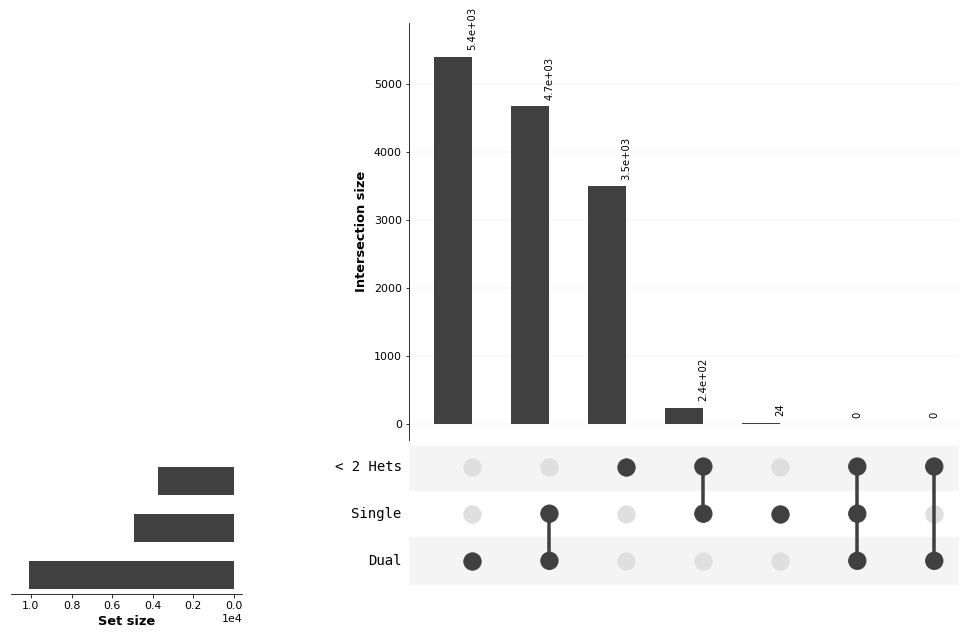

In [23]:
fig = pyu.plot(upset_plot_dict, unique_keys=['official_gene_symbol'])

In [26]:
fig

{'additional': [],
 'base_set_size': <matplotlib.axes._subplots.AxesSubplot at 0x7faba85382e8>,
 'figure': <matplotlib.figure.Figure at 0x7faba9df1390>,
 'intersection_bars': <matplotlib.axes._subplots.AxesSubplot at 0x7faba81405f8>,
 'intersection_matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7faba852d2b0>,
 'names': <matplotlib.axes._subplots.AxesSubplot at 0x7faba8200780>}

In [27]:
fig['figure'].savefig('single_vs_dual_wtc_hg19.pdf', dpi=300)